In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

In [2]:
with open('genre_dictionary.pkl', 'rb') as f:
    genre_dict = pickle.load(f)

In [21]:
retrieval_path = './retrieved_ids/'
files = ['baseline_retrieved_ids.pkl', 'cosine_retrieved_ids.pkl', 'inner_product_retrieved_ids.pkl', 'essentia_cosine_retrieved_ids.pkl', 
        'essentia_inner_product_retrieved_ids.pkl', 'mfcc_bow_cosine_retrieved_ids.pkl', 'mfcc_bow_inner_product_retrieved_ids.pkl',
        'resnet_cosine_retrieved_ids.pkl', 'resnet_inner_product_retrieved_ids.pkl', 'vgg19_cosine_retrieved_ids.pkl',
        'vgg19_product_retrieved_ids.pkl']

In [27]:
positive_rate = {}
for idx in tqdm(genre_dict):
    p = 0
    for idy in genre_dict:
        if func(genre_dict[idx], genre_dict[idy]):
            p += 1
    positive_rate[idx] = p
with open(f'positive_rate.pkl', 'wb') as f:
    pickle.dump(positive_rate, f)

100%|█████████████████████████████████████| 68641/68641 [43:34<00:00, 26.25it/s]


In [22]:
def func(a, b):
    return not set(a).isdisjoint(b)

def precision(song_id: str, k: int, retrieved_dict: dict, genre_dict: dict):
    top_k_ids = retrieved_dict[song_id][:k]
    query_genre = genre_dict[song_id]
    # print(query_genre)
    tp = 0
    prec_list = []
    for idx, ids in enumerate(top_k_ids):
        genres = genre_dict[ids]
        # print(genres)
        if any(item in query_genre for item in genres):
            tp += 1
        prec = tp / (idx+1)
        prec_list.append(prec)
    return np.array(prec_list)

def recall(song_id: str, k: int, retrieved_dict: dict, genre_dict: dict, positive_rate: dict):
    top_k_ids = retrieved_dict[song_id][:k]
    query_genre = genre_dict[song_id]
    # print(query_genre)
    rec_list = []
    tp = 0
    p = positive_rate[song_id]
    for idx in top_k_ids:
        genres = genre_dict[idx]
        # print(genres)
        if any(item in query_genre for item in genres):
            tp += 1
        recall = tp / p
        rec_list.append(recall)
    return np.array(rec_list)

def precision_recall(retrieval_path: str, k: int=100):
    with open(retrieval_path, 'rb') as f:
        retrieved_dict = pickle.load(f)
    with open('genre_dictionary.pkl', 'rb') as f:
        genre_dict = pickle.load(f)
    with open(f'positive_rate.pkl', 'rb') as f:
        positive_rate = pickle.load(f)
    prec_list = np.zeros(k)
    recall_list = np.zeros(k)
    for song_id in retrieved_dict:
        prec_list = prec_list + precision(song_id, k, retrieved_dict, genre_dict)
        recall_list = recall_list + recall(song_id, k, retrieved_dict, genre_dict, positive_rate)
    prec_list = prec_list/len(retrieved_dict)
    recall_list = recall_list/len(retrieved_dict)
    return prec_list, recall_list

In [23]:
p_dict = {}
r_dict = {}
for file in files:
    precis, reca = precision_recall(retrieval_path+file, 100)
    p_dict[file] = precis
    r_dict[file] = reca

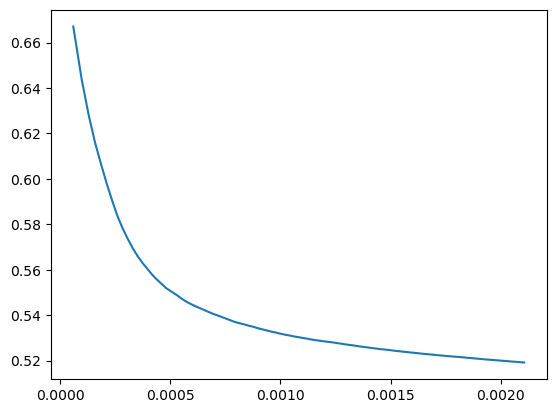

In [8]:
plt.plot(reca, precis)
plt.show()

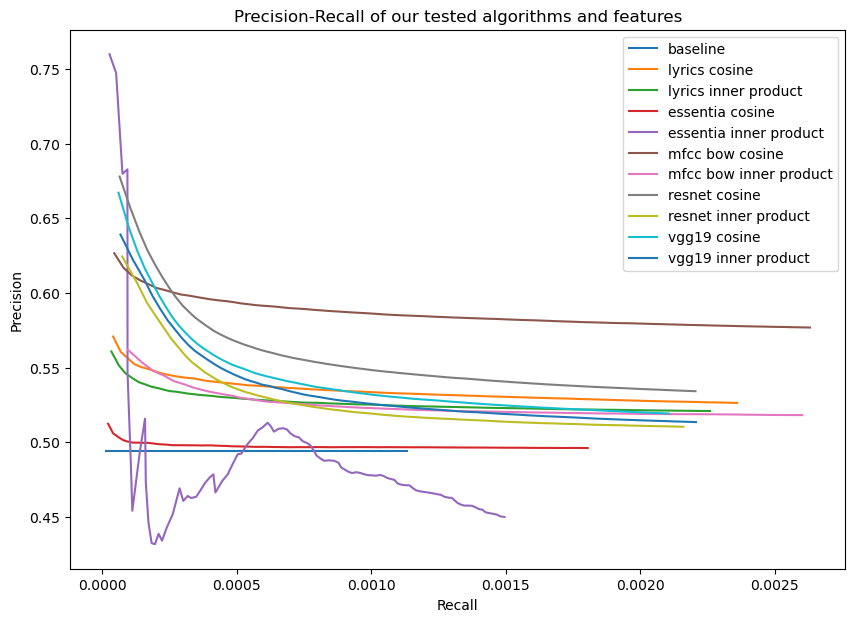

In [29]:
labels = ['baseline', 'lyrics cosine', 'lyrics inner product', 'essentia cosine', 'essentia inner product', 
          'mfcc bow cosine', 'mfcc bow inner product','resnet cosine', 'resnet inner product', 'vgg19 cosine',
          'vgg19 inner product ']
plt.figure(figsize=(10,7))
for idx, file in enumerate(files):
    plt.plot(r_dict[file], p_dict[file], label=labels[idx])

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Precision-Recall of our tested algorithms and features')
plt.legend()
plt.savefig('prec_recall_plot.png')
plt.show()